In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [3]:
using Blink

In [4]:
robot = BoxAtlas(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 2280`, ProcessRunning), TCPSocket(RawFD(68) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(1, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(55) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 1, Nullable{Any}(true))))

In [5]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params, false)
net, loss = LearningMPC.interval_net([22, 48, 48, 1]; regularization=1e-3)
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [6]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sink)
#         copy!(x0, x_init)
#         set_velocity!(x0, findjoint(x0.mechanism, "floating_base"),
#             [σv * (2 * (rand() - 0.5)), 0.0, 0.0])
        LearningMPC.randomize!(x0, x_init, 0.0, σv)
#         Δv = zeros(num_velocities(x0))
#         Δv[1] = σv * (2 * rand() - 0.5)
#         set_velocity!(x0, velocity(x0) .+ Δv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 25, 
            params.lcp_solver;
            termination=x -> configuration(x)[3] > π/4 || configuration(x)[3] < -π/4);
        append!(data, sink.samples)
    end
end

(::#1) (generic function with 1 method)

In [7]:
library_file = "library.jld2"
dataset_file = "boxatlas-regularized.jld2"

"boxatlas-regularized.jld2"

Note: the library was initialized by taking the libraries from the 20th and the 21st, combining and shuffling them as below:

In [8]:
# t, v = jldopen("../2018-08-20-box-atlas-miqp/library.jld2") do file
#     file["training"], file["testing"]
# end
# old_samples = vcat(t, v);
# t, v = jldopen("../2018-08-21-comparing-mimic-and-bounds/library.jld2") do file
#     file["training"], file["testing"]
# end
# append!(old_samples, t)
# append!(old_samples, v)

# t, v = jldopen("../2018-08-21-comparing-mimic-and-bounds/library-mimic.jld2") do file
#     file["training"], file["testing"]
# end
# append!(old_samples, t)
# append!(old_samples, v)

# t, v = splitobs(shuffleobs(old_samples); at=0.8)
# jldopen(library_file, "w") do file
#     file["training"] = Vector(t)
#     file["testing"] = Vector(v)
# end;

In [9]:
if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;


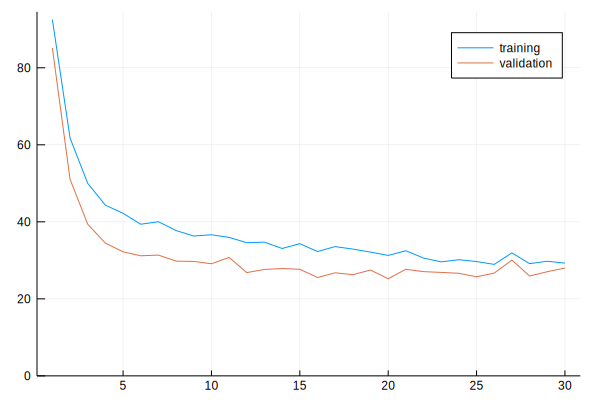

1136.966442 seconds (2.83 G allocations: 526.616 GiB, 12.50% gc time)


Progress:  10%|████                                     |  ETA: 3:58:06

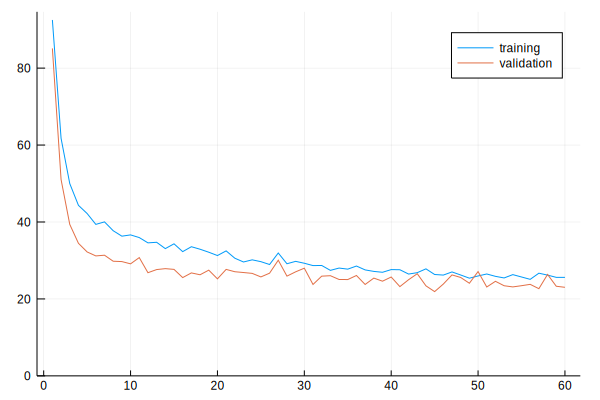

1155.346988 seconds (2.83 G allocations: 527.453 GiB, 13.62% gc time)


Progress:  20%|████████                                 |  ETA: 3:30:12

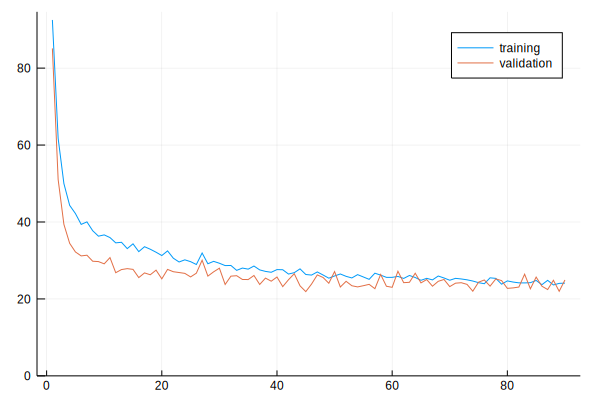

1168.388467 seconds (2.84 G allocations: 528.389 GiB, 13.52% gc time)


Progress:  30%|████████████                             |  ETA: 3:04:15

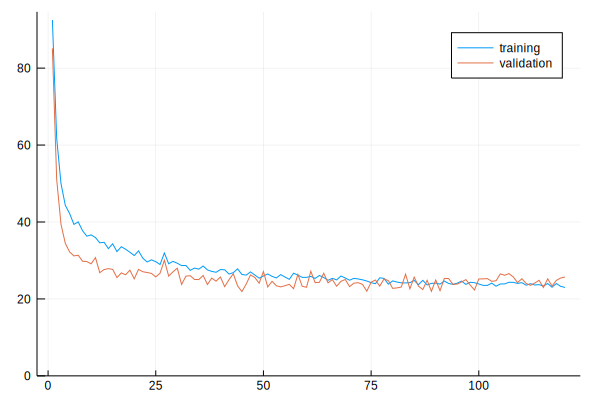

1380.593412 seconds (2.84 G allocations: 529.325 GiB, 12.61% gc time)


Progress:  40%|████████████████                         |  ETA: 2:43:00

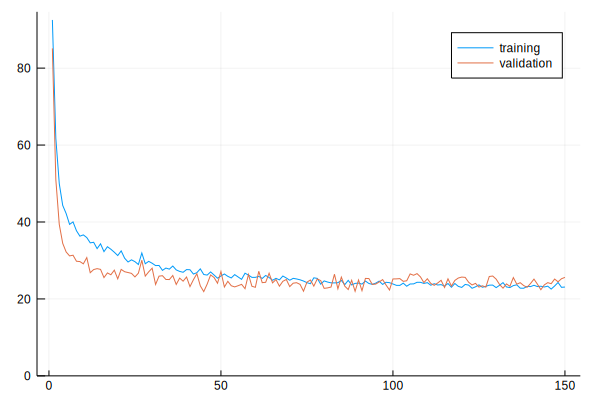

1357.109243 seconds (2.85 G allocations: 530.165 GiB, 12.77% gc time)


Progress:  50%|████████████████████                     |  ETA: 2:17:22

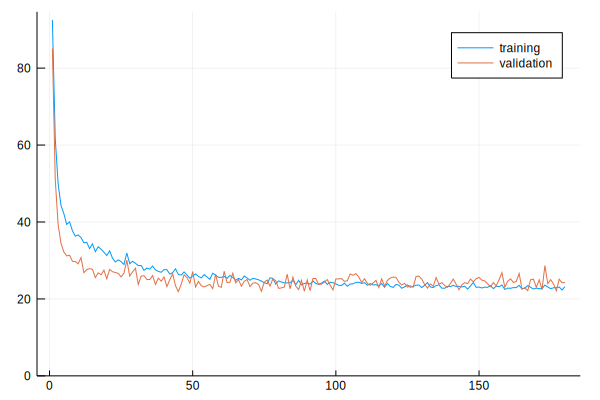

1460.635739 seconds (2.85 G allocations: 531.101 GiB, 12.12% gc time)


Progress:  60%|█████████████████████████                |  ETA: 1:52:39

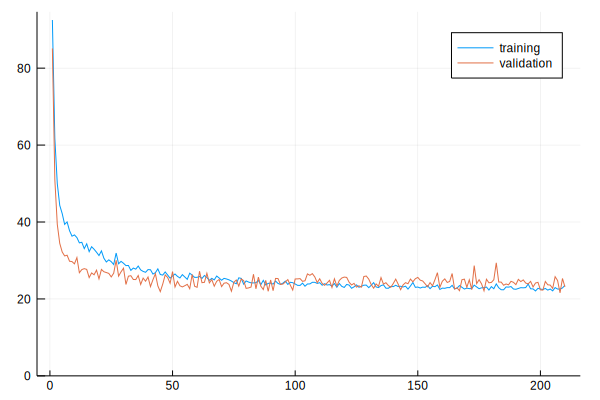

1431.874346 seconds (2.86 G allocations: 531.801 GiB, 12.37% gc time)


Progress:  70%|█████████████████████████████            |  ETA: 1:24:51

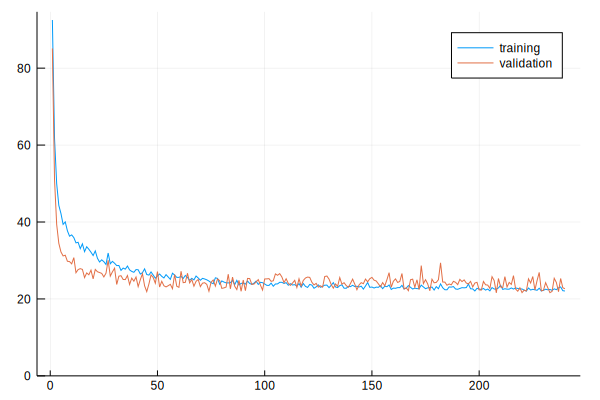

1513.693858 seconds (2.86 G allocations: 532.737 GiB, 11.88% gc time)


Progress:  80%|█████████████████████████████████        |  ETA: 0:57:32

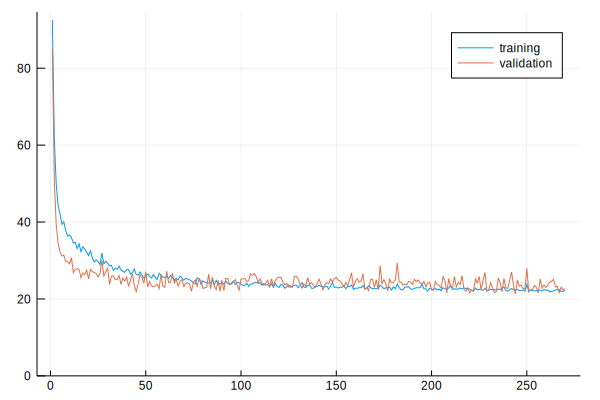

1571.746725 seconds (2.87 G allocations: 533.514 GiB, 11.67% gc time)


Progress:  90%|█████████████████████████████████████    |  ETA: 0:29:10

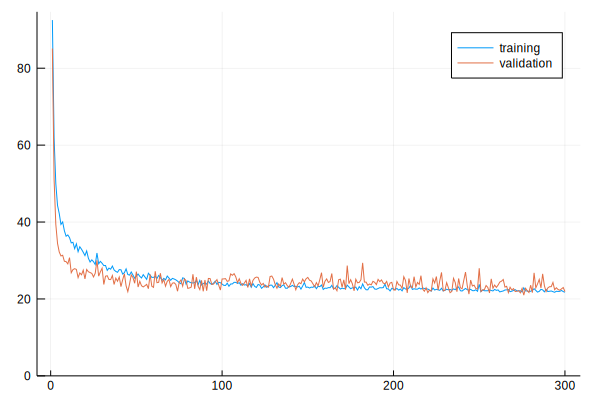

1400.260212 seconds (2.87 G allocations: 534.450 GiB, 12.29% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 4:53:15


In [10]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 10
σv = 3.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:3
        collect_into!(dataset.training_data, σv * i / N_iter)
    end
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end
    
    new_samples = tuple.(dataset.training_data)
    new_training, new_validation = splitobs(shuffleobs(new_samples); at=0.8)
    append!(all_training_data, new_training)
    append!(all_validation_data, new_validation)

    @time for i in 1:30
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen(dataset_file, "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
#     jldopen(library_file, "w") do file
#         file["training"] = all_training_data
#         file["testing"] = all_validation_data
#     end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)

end